<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/Link_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

In [ ]:
!pip install sentence_transformers

# Data Load

In [4]:
# MovieLens dataset (Heterogeneous data type)

from torch_geometric.datasets import MovieLens

dataset = MovieLens('movieslens')

Extracting movieslens/raw/ml-latest-small.zip
Processing...


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Done!


In [5]:
print(len(dataset))
print(dataset[0])

1
HeteroData(
  movie={ x=[9742, 404] },
  user={ num_nodes=610 },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  }
)


In [6]:
data = dataset[0]

In [7]:
print(data.metadata())
print()

print('Node types      : {}'.format(data.metadata()[0]))
print('Edge types      : {}'.format(data.metadata()[1]))
print()

print("Isolated nodes  : {}".format(data.has_isolated_nodes()))      # 고립된 노드가 존재한다.
print('Self loop       : {}'.format(data.has_self_loops()))
print('Undirect        : {}'.format(data.is_undirected()))


(['movie', 'user'], [('user', 'rates', 'movie')])

Node types      : ['movie', 'user']
Edge types      : [('user', 'rates', 'movie')]

Isolated nodes  : True
Self loop       : False
Undirect        : False


In [8]:
import numpy as np

print(data['user'])
print(data['movie'])
print(data['movie']['x'].shape)
print()

# print(data[('user', 'rates', 'movie')])
print(data['rates'])
print()

print(data['rates']['edge_index'].shape)
print(data['rates']['edge_index'][0])
print()

print(data['rates']['edge_label'].shape)
print(data['rates']['edge_label'][:10])


{'num_nodes': 610}
{'x': tensor([[-0.0828,  0.0530,  0.0536,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1053,  0.1508, -0.0264,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0988,  0.0176, -0.0527,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1115,  0.0310, -0.0177,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0366,  0.0137,  0.0315,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0500, -0.0141, -0.0031,  ...,  0.0000,  0.0000,  0.0000]])}
torch.Size([9742, 404])

{'edge_index': tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]]), 'edge_label': tensor([4, 4, 4,  ..., 5, 5, 3])}

torch.Size([2, 100836])
tensor([  0,   0,   0,  ..., 609, 609, 609])

torch.Size([100836])
tensor([4, 4, 4, 5, 5, 3, 5, 4, 5, 5])


In [9]:
print(data['rates'])
print(data['rates'].edge_index)
print(data['rates'].edge_label)

{'edge_index': tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]]), 'edge_label': tensor([4, 4, 4,  ..., 5, 5, 3])}
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]])
tensor([4, 4, 4,  ..., 5, 5, 3])


In [10]:
import torch

# print(data['user'].x)               # there are no 'x' value
print(data['user'].num_nodes)
print(torch.eye(data['user'].num_nodes))

data['user'].x = torch.eye(data['user'].num_nodes)        # (nodes) -> (nodes, nodes)

print(data['user'].x.shape)
print(data['user'].x)

610
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
torch.Size([610, 610])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [11]:
import torch_geometric.transforms as T

print(data)
print()

data = T.ToUndirected()(data)       # add a reverse relation (edge_type)

print(data)

del data['movie', 'rev_rates', 'user'].edge_label

print(data)

HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  }
)

HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={
    edge_index=[2, 100836],
    edge_label=[100836]
  }
)
HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


In [12]:

counts = torch.bincount(data['user', 'movie'].edge_label)
print(counts)
print(counts.max())

weight = counts.max() / counts

print(weight)

tensor([ 1370,  4602, 13101, 33183, 35369, 13211])
tensor(35369)
tensor([25.8168,  7.6856,  2.6997,  1.0659,  1.0000,  2.6772])


In [13]:

# Link level split
train_data, val_data, test_data = T.RandomLinkSplit(num_val = 0.2, num_test = 0.1, neg_sampling_ratio = 0,
                                                    edge_types = [('user', 'rates', 'movie')],
                                                    rev_edge_types = [('movie', 'rev_rates', 'user')])(data)

print(train_data)
# print()
# print(val_data)
# print()
# print(test_data)

dataset = (train_data, val_data, test_data)


HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_index=[2, 70586],
    edge_label=[70586],
    edge_label_index=[2, 70586]
  },
  (movie, rev_rates, user)={ edge_index=[2, 70586] }
)


# Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import to_hetero
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear


class Graph_Encoder(nn.Module):
  def __init__(self, hidden_channels, out_channels, conv_type):
    super().__init__()
    conv = conv_type

    self.conv1 = conv((-1,-1), hidden_channels)
    self.conv2 = conv((-1,-1), out_channels)

  def forward(self, x, edge_index):
    X = self.conv1(x, edge_index)
    X = F.relu(X)
    X = self.conv2(x, edge_index)
    return X


class Edge_Decoder(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    
    self.linear1 = Linear(hidden_channels * 2, hidden_channels)
    self.linear2 = Linear(hidden_channels, 1)

  def forward(self, z_dict, edge_label_index):
    row, col = edge_label_index               # row : ('user', 'rates', 'movie'), col : ('movie', 'rev_rates', 'user')

    # print(z_dict['user'][row])
    # print(z_dict['movie'][col])
    # print()

    Z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim = -1)
    # print(Z)

    Z = self.linear1(Z)
    Z = F.relu(Z)
    Z = self.linear2(Z)
    Z = Z.view(-1)

    return Z


class Model(nn.Module):
  def __init__(self, hidden_channels, conv_type, data):
    super().__init__()

    conv = conv_type

    self.encoder = Graph_Encoder(hidden_channels, hidden_channels, conv)
    self.hetero_encoder = to_hetero(self.encoder, data.metadata(), aggr = 'sum')
    self.decoder = Edge_Decoder(hidden_channels)

  def forward(self, x_dict, edge_index_dict, edge_label_index):

    z_dict = self.hetero_encoder(x_dict, edge_index_dict)
    output = self.decoder(z_dict, edge_label_index)

    return output



In [15]:
# train data
print(train_data.metadata())
print()

print(train_data.x_dict)
print(train_data.edge_index_dict)
print(train_data['user', 'rates', 'movie'].edge_label_index)

x_dict = train_data.x_dict
edge_index_dict = train_data.edge_index_dict
edge_label_index = train_data['user', 'rates', 'movie'].edge_label_index


(['movie', 'user'], [('user', 'rates', 'movie'), ('movie', 'rev_rates', 'user')])

{'movie': tensor([[-0.0828,  0.0530,  0.0536,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1053,  0.1508, -0.0264,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0988,  0.0176, -0.0527,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1115,  0.0310, -0.0177,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0366,  0.0137,  0.0315,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0500, -0.0141, -0.0031,  ...,  0.0000,  0.0000,  0.0000]]), 'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])}
{('user', 'rates', 'movie'): tensor([[ 248,  598,  134,  ...,  598,  596,  274],
        [7906, 4186, 1031,  ..., 2523,  108,  383]]), ('movie', 'rev_rates', 'user'): tensor([[7906, 4186, 1031,  ..., 2523,  10

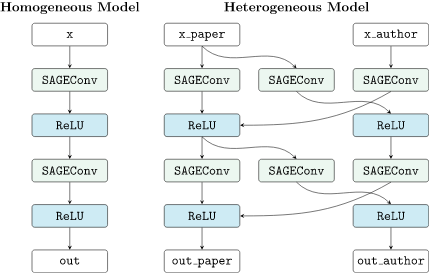

In [16]:
hidden_channels = 32
conv_type = SAGEConv

encoder = Graph_Encoder(hidden_channels, hidden_channels, conv_type)
print("========= encoder ========= \n {}".format(encoder))
print()

hetero_encoder = to_hetero(encoder, train_data.metadata(), aggr = 'sum')
print("===== hetero encoder ===== \n {}".format(hetero_encoder))
print()


encoder_output = hetero_encoder(x_dict, edge_index_dict)
print(encoder_output)
print()
print(encoder_output['movie'].shape)
print(encoder_output['user'].shape)


========= encoder ========= 
 Graph_Encoder(
  (conv1): SAGEConv((-1, -1), 32)
  (conv2): SAGEConv((-1, -1), 32)
)

===== hetero encoder ===== 
 GraphModule(
  (conv1): ModuleDict(
    (movie): SAGEConv((-1, -1), 32)
    (user): SAGEConv((-1, -1), 32)
  )
  (conv2): ModuleDict(
    (user__rates__movie): SAGEConv((-1, -1), 32)
    (movie__rev_rates__user): SAGEConv((-1, -1), 32)
  )
)



def forward(self, x, edge_index):
    x__movie = x.get('movie')
    x__user = x.get('user');  x = None
    edge_index__user__rates__movie = edge_index.get(('user', 'rates', 'movie'))
    edge_index__movie__rev_rates__user = edge_index.get(('movie', 'rev_rates', 'user'));  edge_index = None
    conv2__movie = self.conv2.user__rates__movie((x__user, x__movie), edge_index__user__rates__movie);  edge_index__user__rates__movie = None
    conv2__user = self.conv2.movie__rev_rates__user((x__movie, x__user), edge_index__movie__rev_rates__user);  x__movie = x__user = edge_index__movie__rev_rates__user = None
   

In [17]:
decoder = Edge_Decoder(hidden_channels)
print("======== decoder ======== \n {}".format(decoder))

# encoder_output = {'movie' : [tensor], 'user' : [tensor]}
# edge_label_index = ('user', 'rates', 'movie') : [tensor], ('movie', 'rev_rates', 'user') : [tensor]}

output = decoder(encoder_output, edge_label_index)

print(output.shape)
print(output)

======== decoder ======== 
 Edge_Decoder(
  (linear1): Linear(64, 32, bias=True)
  (linear2): Linear(32, 1, bias=True)
)
torch.Size([70586])
tensor([0.0190, 0.0324, 0.0253,  ..., 0.0331, 0.0180, 0.0205],
       grad_fn=<ViewBackward0>)


In [33]:
model = Model(hidden_channels, conv_type, train_data)
print(model)
print()

output = model(x_dict, edge_index_dict, edge_label_index)
print(output.shape)
print(output)
print()

target = train_data['user', 'movie'].edge_label         # rating scores

print(target.shape)
print(target)

Model(
  (encoder): Graph_Encoder(
    (conv1): SAGEConv((-1, -1), 32)
    (conv2): SAGEConv((-1, -1), 32)
  )
  (hetero_encoder): GraphModule(
    (conv1): ModuleDict(
      (movie): SAGEConv((-1, -1), 32)
      (user): SAGEConv((-1, -1), 32)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32)
    )
  )
  (decoder): Edge_Decoder(
    (linear1): Linear(64, 32, bias=True)
    (linear2): Linear(32, 1, bias=True)
  )
)

torch.Size([70586])
tensor([-0.0400, -0.0388, -0.0325,  ..., -0.0431, -0.0329, -0.0291],
       grad_fn=<ViewBackward0>)

torch.Size([70586])
tensor([4, 2, 3,  ..., 4, 4, 4])


# Experiment

In [34]:
def trainer(train_data, model, optimizer, weight, criterion):

  x_dict = train_data.x_dict
  edge_index_dict = train_data.edge_index_dict
  edge_label_index = train_data['user', 'rates', 'movie'].edge_label_index
  target = train_data['user', 'movie'].edge_label

  model.train()
  optimizer.zero_grad()

  pred = model(x_dict, edge_index_dict, edge_label_index)

  loss = criterion(pred, target, weight)

  loss.backward()
  optimizer.step()

  return loss


@torch.no_grad()
def tester(test_data, model):

  x_dict = test_data.x_dict
  edge_index_dict = test_data.edge_index_dict
  edge_label_index = test_data['user', 'movie'].edge_label_index
  target = test_data['user', 'movie'].edge_label

  model.eval()

  pred = model(x_dict, edge_index_dict, edge_label_index)
  pred = pred.clamp(min=0, max = 5)

  mse = F.mse_loss(pred, target)
  rmse = mse.sqrt()

  return rmse


In [35]:
# 해당 데이터 셋의 rating 에 해당하는 label들은 불균형하게 분포되어 있기 때문에 학습 과정에서 이를 반영하도록 한다.

def weighted_mse_loss(pred, target, weight=None):

  if weight is None:
    weight = 1.
  else:
    weight = weight[target].to(pred.dtype)

  result = (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

  return result

In [36]:
print(weight)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = weighted_mse_loss

loss = trainer(train_data, model, optimizer, weight, criterion)
rmse = tester(train_data, model)

print(loss)
print(rmse)

tensor([25.8168,  7.6856,  2.6997,  1.0659,  1.0000,  2.6772])
tensor(19.6319, grad_fn=<MeanBackward0>)
tensor(3.5217)


In [37]:
from collections import defaultdict

def experiment(dataset, model, optimizer, weight, criterion, EPOCHS):

  train_data, val_data, test_data = dataset

  scores = defaultdict(list)
  best_score_index = 0

  for epoch in range(EPOCHS):
    scores['loss'] += [trainer(train_data, model, optimizer, weight, criterion).item()]

    scores['train_rmse'] += [tester(train_data, model).item()]
    scores['val_rmse'] += [tester(val_data, model).item()]
    scores['test_rmse'] += [tester(test_data, model).item()]

    if epoch % 100 == 0:
      print("epoch : {}, train rmse : {}".format(epoch + 1, scores['train_rmse'][-1]))

  return dict(scores)


In [38]:
EPOCHS = 100

scores = experiment(dataset, model, optimizer, weight, criterion, EPOCHS)

epoch : 1, train rmse : 3.5082457065582275


In [39]:
print(scores['loss'][:5])
print(scores['train_rmse'][:5])
print(scores['val_rmse'][:5])
print(scores['test_rmse'][:5])

[19.384340286254883, 19.13047981262207, 18.8736572265625, 18.619144439697266, 18.369441986083984]
[3.5082457065582275, 3.48484468460083, 3.461397171020508, 3.438180923461914, 3.4146227836608887]
[3.5091030597686768, 3.4857046604156494, 3.462272882461548, 3.439070701599121, 3.4155266284942627]
[3.5207905769348145, 3.497406244277954, 3.4739973545074463, 3.450822114944458, 3.4273157119750977]


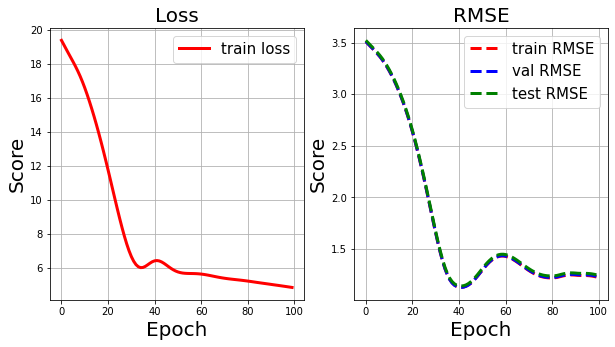

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize = (10,5))

# loss
axes[0].plot(scores['loss'], c = 'r', linestyle = 'solid', linewidth = 3)

# axes[0].set_ylim(0,5)

axes[0].grid()

axes[0].set_title("Loss", fontsize=20)
axes[0].set_xlabel('Epoch', fontsize = 20)
axes[0].set_ylabel('Score', fontsize = 20)

axes[0].legend(['train loss'], fontsize = 15)


# rmse
axes[1].plot(scores['train_rmse'], c = 'r', linestyle = 'dashed', linewidth = 3)
axes[1].plot(scores['val_rmse'], c = 'b', linestyle = 'dashed', linewidth = 3)
axes[1].plot(scores['test_rmse'], c = 'g', linestyle = 'dashed', linewidth = 3)

# axes[1].set_ylim(0,2)

axes[1].grid()

axes[1].set_title("RMSE", fontsize=20)
axes[1].set_xlabel('Epoch', fontsize = 20)
axes[1].set_ylabel('Score', fontsize = 20)

axes[1].legend(['train RMSE', 'val RMSE', 'test RMSE'], fontsize = 15)


# plot
plt.show()



# Hyperparameter Tuning

In [67]:
from itertools import product
import pandas as pd

i = 0

# hyperparameters
hidden_channels = [16, 32, 64]
learning_rates = [0.01, 0.005, 0.001]
conv_types = [SAGEConv, GATConv]

EPOCHS = 5


# grid search

cols = ['hidden channels', 'learning rate', 'conv type', 'train loss', 'train RMSE', 'val RMSE', 'test RMSE']
best_perform_df = pd.DataFrame(columns = cols)

scores_dict = defaultdict(lambda: dict)
for hc, lr, ct in product(hidden_channels, learning_rates, conv_types):
  i += 1

  conv_name = str(ct).split('.')[-1].replace('\'>', "")
  print('case :{}, hidden channels : {}, learning rate : {}, conv type : {}'.format(i, hc, lr, conv_name))
  
  # create model
  model = Model(hc, ct, data)

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  criterion = weighted_mse_loss

  # experiment
  scores = experiment(dataset, model, optimizer, weight, criterion, EPOCHS)

  # scores save
  scores_dict[i] = scores

  best_perform_idx = np.argmin(scores['val_rmse'] + scores['test_rmse'])
  best_perform_df.loc[i] = [hc,
                            lr,
                            conv_name,
                            scores['loss'][best_perform_idx],
                            scores['train_rmse'][best_perform_idx],
                            scores['val_rmse'][best_perform_idx],
                            scores['test_rmse'][best_perform_idx]]
  

best_perform_df = best_perform_df.sort_values(by='test RMSE')
scores_dict = dict(scores_dict)


case :1, hidden channels : 16, learning rate : 0.01, conv type : SAGEConv
epoch : 1, train rmse : 3.3753209114074707
case :2, hidden channels : 16, learning rate : 0.01, conv type : GATConv
epoch : 1, train rmse : 3.397775650024414
case :3, hidden channels : 16, learning rate : 0.005, conv type : SAGEConv
epoch : 1, train rmse : 3.169682025909424
case :4, hidden channels : 16, learning rate : 0.005, conv type : GATConv
epoch : 1, train rmse : 3.353442430496216
case :5, hidden channels : 16, learning rate : 0.001, conv type : SAGEConv
epoch : 1, train rmse : 3.522026300430298
case :6, hidden channels : 16, learning rate : 0.001, conv type : GATConv
epoch : 1, train rmse : 3.522026300430298
case :7, hidden channels : 32, learning rate : 0.01, conv type : SAGEConv
epoch : 1, train rmse : 3.361759662628174
case :8, hidden channels : 32, learning rate : 0.01, conv type : GATConv
epoch : 1, train rmse : 3.3936169147491455
case :9, hidden channels : 32, learning rate : 0.005, conv type : SAGE

In [68]:
best_perform_df

,hidden channels,learning rate,conv type,train loss,train RMSE,val RMSE,test RMSE
13,64,0.010,SAGEConv,12.347196,1.103836,1.100022,1.109338
7,32,0.010,SAGEConv,6.319886,1.109743,1.105199,1.115776
14,64,0.010,GATConv,6.258432,1.202011,1.194513,1.202473
8,32,0.010,GATConv,7.429623,1.257177,1.257438,1.270993
15,64,0.005,SAGEConv,9.616459,1.813012,1.814368,1.828726
1,16,0.010,SAGEConv,10.349600,2.006440,2.007850,2.021320
16,64,0.005,GATConv,12.437274,2.433258,2.436533,2.448513
9,32,0.005,SAGEConv,12.247480,2.507768,2.508846,2.521603
2,16,0.010,GATConv,12.757686,2.526118,2.528558,2.540566
3,16,0.005,SAGEConv,12.417210,2.609036,2.610143,2.622712


In [66]:
# dict of dict

print(scores_dict.keys())
print(scores_dict[1].keys())
print(scores_dict[1]['loss'][:5])

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
dict_keys(['loss', 'train_rmse', 'val_rmse', 'test_rmse'])
[4.031390190124512, 4.009430885314941, 3.9876980781555176, 3.9662113189697266, 3.9449894428253174]
